## Convolutional Neural Networks
### Project: an Algorithm for a Dog Identification App

The goal is to build a pipeline that can be used within a web or mobile app to process real-world, user-supplied images. Given an image of a dog, the algorithm will identify an estimate of the canine’s breed. If supplied an image of a human, the code will identify the resembling dog breed.

In [1]:
# necessary imports
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import sys
import os
import dlib
from skimage import io
from tqdm import tqdm
from glob import glob
from sklearn.datasets import load_files
from extract_bottleneck_features import *
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.utils import np_utils
from PIL import ImageFile
from IPython.core.display import Image, display

In [2]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('img/dogImages/train')
valid_files, valid_targets = load_dataset('img/dogImages/valid')
test_files, test_targets = load_dataset('img/dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("img/dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset
In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array human_files.

In [3]:
%matplotlib inline     

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/hf.xml')

random.seed(666)

# load filenames in shuffled human dataset
human_files = np.array(glob("img/lfw/*/*"))
#random.shuffle(human_files)

In [4]:

def boxe_face(image):
    # load color (BGR) image
    img = cv2.imread(image)
    # convert BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # find faces in image
    faces = face_cascade.detectMultiScale(gray)
    # print number of faces detected in the image
    print (faces)
    print('Number of faces detected:', len(faces))
    # get bounding box for each detected face
    for (x,y,w,h) in faces:
        # add bounding box to color image
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()

[[ 71  70 109 109]]
Number of faces detected: 1


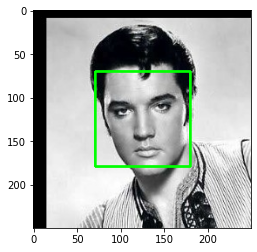

There are 13233 total human images.


In [5]:
boxe_face(human_files[3])

# print statistics about the dataset
print("Good ol' Elvis")
print('There are %d total human images.' % len(human_files))

## Step 1: Detect Humans
We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images. OpenCV provides many pre-trained face detectors, stored as XML files on github. We have downloaded one of these detectors and stored it in the haarcascades directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Before using any of the face detectors, it is standard procedure to convert the images to grayscale. The ```detectMultiScale``` function executes the classifier stored in ```face_cascade``` and takes the grayscale image as a parameter.

In the above code, faces is a numpy array of detected faces, where each row corresponds to a detected face. Each detected face is a 1D array with four entries that specifies the bounding box of the detected face. The first two entries in the array (extracted in the above code as x and y) specify the horizontal and vertical positions of the top left corner of the bounding box. The last two entries in the array (extracted here as w and h) specify the width and height of the box.

### Write a Human Face Detector
We can use this procedure to write a function that returns True if a human face is detected in an image and False otherwise. This function, aptly named face_detector, takes a string-valued file path to an image as input and appears in the code block below.

In [6]:
# returns "True" if face is detected in image stored at img_path
def face_detector_opencv(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

What percentage of the first 100 images in ```human_files``` have a detected human face?
What percentage of the first 100 images in ```dog_files``` have a detected human face?

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face. We will see that our algorithm falls short of this goal, but still gives acceptable performance. We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays ```human_files_short``` and ```dog_files_short```.

So we see that the OpenCV's implementation of Haar feature-based cascade classifiers detects 100.0% of faces in the first 100 images in ```human_files``` and 11.0% of faces in the first 100 images in ```dog_files```. When investigating each image where a face has been detected, we can see that for one image there is actually a human in the picture so the classifier is not making a mistake here. For 4 images, the classifier misclassifies the face of a human with a dog. For the rest of them, the classifier seems to detect faces in fur, wrinkle of fabrics...

98.0% of faces detected in the first 100 images in human_files by OpenCV
[[160 159 108 108]]
Number of faces detected: 1


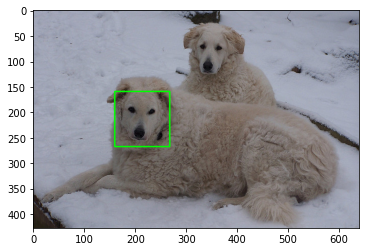

[[188 139 102 102]]
Number of faces detected: 1


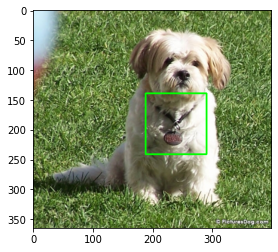

[[202  96  47  47]]
Number of faces detected: 1


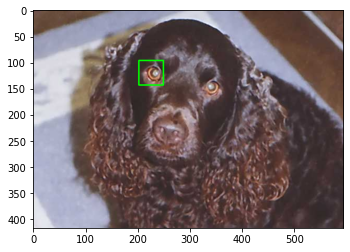

[[235 174  83  83]]
Number of faces detected: 1


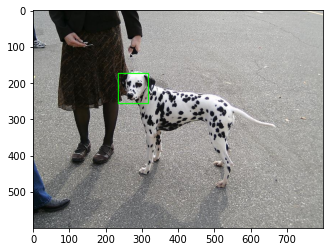

[[107  38 247 247]]
Number of faces detected: 1


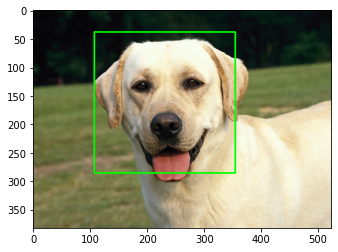

[[237 135  48  48]]
Number of faces detected: 1


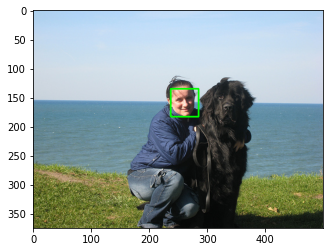

[[366 137  34  34]]
Number of faces detected: 1


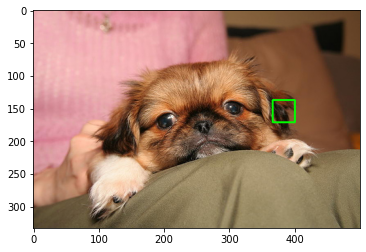

[[1078 1034   44   44]]
Number of faces detected: 1


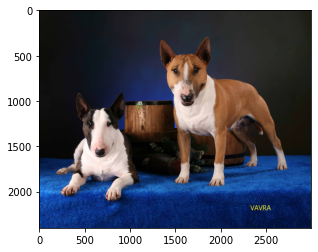

[[390 322  50  50]]
Number of faces detected: 1


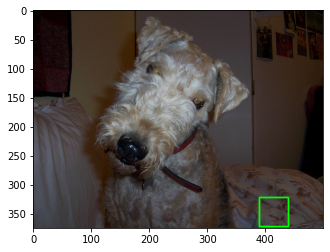

[[136 452  48  48]]
Number of faces detected: 1


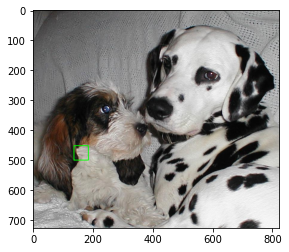

[[164 265 223 223]]
Number of faces detected: 1


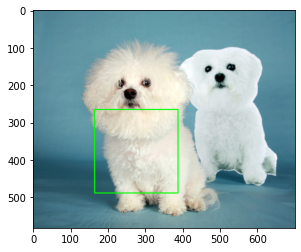

[[302  58  96  96]]
Number of faces detected: 1


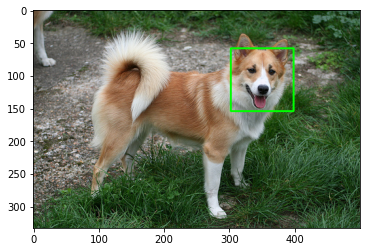

12.0% of faces detected in the first 100 images in dog_files by OpenCV


In [7]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
def performance_face_detector_opencv(human_files_short, dog_files_short):
    face_human = [int(face_detector_opencv(human_img)) for human_img in human_files_short]
    ratio_human = sum(face_human)/len(face_human)*100
    print ('{}% of faces detected in the first 100 images in human_files by OpenCV'.format(ratio_human))

    face_dog = 0
    for dog_img in dog_files_short:
        if face_detector_opencv(dog_img):
            img = cv2.imread(dog_img)
            boxe_face(dog_img)
            face_dog += 1 
    ratio_dog = face_dog/len(dog_files_short)*100
    print ('{}% of faces detected in the first 100 images in dog_files by OpenCV'.format(ratio_dog))

performance_face_detector_opencv(human_files_short, dog_files_short)


## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images. Our first line of code downloads the ResNet-50 model, along with weights that have been trained on ImageNet, a very large, very popular dataset used for image classification and other vision tasks. ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [8]:
# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

## Pre-process the Data
When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
    (nb\_samples,rows,columns,channels),
$$
where nb_samples corresponds to the total number of images (or samples), and rows, columns, and channels correspond to the number of rows, columns, and channels for each image, respectively.

The path_to_tensor function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN. The function first loads the image and resizes it to a square image that is  224×224
  pixels. Next, the image is converted to an array, which is then resized to a 4D tensor. In this case, since we are working with color images, each image has three channels. Likewise, since we are processing a single image (or sample), the returned tensor will always have shape
$$
  (1,224,224,3).
$$
The paths_to_tensor function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape
$$
  (nb\_samples,224,224,3).
$$
Here, nb_samples is the number of samples, or number of images, in the supplied array of image paths. It is best to think of nb_samples as the number of 3D tensors (where each 3D tensor corresponds to a different image) in the dataset!

In [9]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

## Making Predictions with ResNet-50
Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing. First, the RGB image is converted to BGR by reordering the channels. All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as  [103.939,116.779,123.68] and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image. This is implemented in the imported function ```preprocess_input```. If you're curious, you can check the code for ```preprocess_input``` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions. This is accomplished with the predict method, which returns an array whose  i-th entry is the model's predicted probability that the image belongs to the  i-th ImageNet category. This is implemented in the ```ResNet50_predict_labels``` function below.

By taking the **argmax** of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

In [10]:
def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

## Write a Dog Detector

While looking at the dictionary, you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from 'Chihuahua' to 'Mexican hairless'. Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the ```ResNet50_predict_labels``` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the ```dog_detector``` function below, which returns True if a dog is detected in an image (and False if not).

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

## Assess the Dog Detector

The pre-trained ResNet-50 model detects 0.0% of dogs in the first 100 images in human_files and 100.0% of faces in the first 100 images in dog_files.

In [12]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
def performance_dog_detector(human_files_short, dog_files_short):
    face_human = 0
    for human_img in human_files_short:
        if dog_detector(human_img):
            display(Image(human_img,width=200,height=200))
            face_human += 1
    ratio_human = face_human/len(human_files_short)*100
    print ('{}% of faces detected in the first 100 images in dog_files with ResNet-50'.format(ratio_human))

    face_dog = [int(dog_detector(dog_img)) for dog_img in dog_files_short]
    ratio_dog = sum(face_dog)/len(face_dog)*100
    print ('{}% of dogs faces in the first 100 images in dog_files with ResNet-50'.format(ratio_dog))



In [13]:
performance_dog_detector(human_files_short, dog_files_short)

0.0% of faces detected in the first 100 images in dog_files with ResNet-50
100.0% of dogs faces in the first 100 images in dog_files with ResNet-50



## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images. In this step, we will create a CNN that classifies dog breeds. We must create our CNN **from scratch**, and we must attain a test accuracy of at least 1%. In Step 5 of this notebook, we will have the opportunity to use **transfer learning** to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers! More parameters means longer training, which means we are more likely to need a GPU to accelerate the training process. Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; we can extrapolate this estimate to figure out how long it will take for our algorithm to train.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging. To see why, consider that even a human would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.

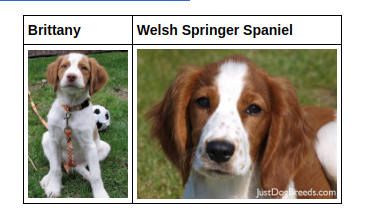

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).

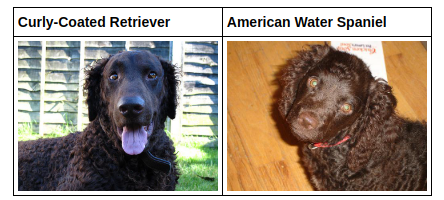

Likewise, recall that labradors come in yellow, chocolate, and black. Our vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.

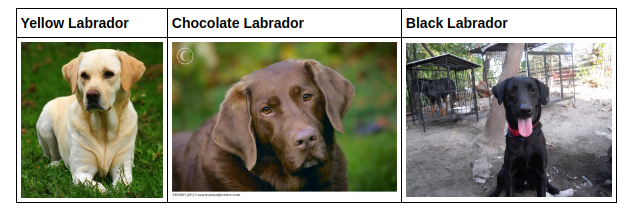

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imbalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.



## Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [14]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

# pre-process the data for Keras
# divide by 255 to normalize the data
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:07<00:00, 119.28it/s]


## Model Architecture

Here we are going to create a CNN to classify dog breed.

I kept the alternation between convolution layers and max pooling layers. For each convolution layers, I increased the number of filters by a factor of 2 starting at 16 filters for the first convolution layer. I also kept the padding as same because it has been documented that this usually yields better results.For each max pooling layers, the dimensions of the input (height and width) are divided by 2 and those are followed by dropout layers to **prevent overfitting**. The last layers are a global average pooling followed by a fully connected layer, where the latter contains one node for each dog category (133) and is equipped with a **Rectified Linear Unit (ReLU) activation function** 



In [15]:
model = Sequential()

### Define my architecture.
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(224, 224, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2, data_format='channels_last'))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2, data_format='channels_last'))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2, data_format='channels_last'))
model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='relu'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        8

In [16]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

## Train the Model

Now we train our model in the code cell below. Using model checkpointing to save the model that attains the best validation loss.


In [12]:
### Specify the number of epochs that you would like to use to train the model.

epochs = 1  #just to run on github ! But you should use 20 or more


checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

334/334 [==============================] - 156s 466ms/step - loss: 12.6729 - accuracy: 0.0097 - val_loss: 12.5649 - val_accuracy: 0.0108

Epoch 00001: val_loss improved from inf to 12.56486, saving model to saved_models/weights.best.from_scratch.hdf5


## Load the Model with the Best Validation Loss

In [17]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

## Test the Model

Trying out our model on the test dataset of dog images. Ensuring that our test accuracy is greater than 1%.

In [18]:
def test_model(model, test_tensors, test_targets, name):
    # get index of predicted dog breed for each image in test set
    predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

    # report test accuracy
    test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
    print('Test accuracy {}: {}%'.format(name, round(test_accuracy, 4)))

In [19]:
test_model(model,test_tensors, test_targets, 'model')


Test accuracy model: 1.1962%



## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we are going to train a CNN using transfer learning.

## Obtain Bottleneck Features

In [26]:
def get_bottleneck_features(path):
    bottleneck_features = np.load(path, allow_pickle=True)
    train = bottleneck_features['train']
    valid = bottleneck_features['valid']
    test = bottleneck_features['test']
    return train, valid, test

In [29]:
train_VGG16, valid_VGG16, test_VGG16 = get_bottleneck_features('bottleneck_features/DogVGG16Data.npz')

## Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model. We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [30]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


In [31]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## Train the Model

In [32]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/20
334/334 [==============================] - 1s 1ms/step - loss: 7.8539 - accuracy: 0.2335 - val_loss: 3.4297 - val_accuracy: 0.4371

Epoch 00001: val_loss improved from inf to 3.42968, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 2/20
334/334 [==============================] - 0s 846us/step - loss: 2.1409 - accuracy: 0.6043 - val_loss: 2.2983 - val_accuracy: 0.6204

Epoch 00002: val_loss improved from 3.42968 to 2.29830, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 3/20
334/334 [==============================] - 0s 839us/step - loss: 1.2017 - accuracy: 0.7439 - val_loss: 2.2533 - val_accuracy: 0.6263

Epoch 00003: val_loss improved from 2.29830 to 2.25334, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 4/20
334/334 [==============================] - 0s 831us/step - loss: 0.8130 - accuracy: 0.8171 - val_loss: 2.0827 - val_accuracy: 0.6659

Epoch 00004: val_loss improved from 2.25334 to 2.08272, saving model to saved_models/weights.best.V

## Load the Model with the Best Validation Loss

In [33]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

## Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images. We print the test accuracy below.

In [34]:
test_model(VGG16_model,test_VGG16, test_targets, 'VGG16')

Test accuracy VGG16: 71.5311%


## Predict Dog Breed with the Model

Trying it on me for the fun of it. I am not a dog but I am curious to see what the model will predict.

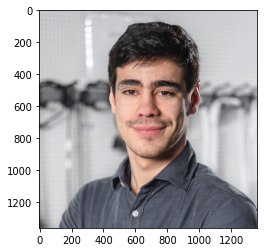

In [63]:

img = cv2.imread("img/me.png")
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()


In [61]:


from keras.preprocessing import image

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]




131.Wirehaired_pointing_griffon


Predicitng: 131.Wirehaired_pointing_griffon


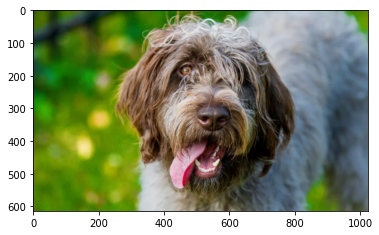

In [64]:

print("Predicitng:", VGG16_predict_breed('img/me.png'))


img = cv2.imread("img/wirehaired.webp")
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()




Well ... it predicted that I am a Wirehaired_pointing_griffon. I am not sure if I should be flattered or insulted. I am not a dog but I do like dogs so I will take it as a compliment.

## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)


We will now use transfer learning to create a CNN that can identify dog breed from images. Our CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features. In this section, we will use the bottleneck features from a different pre-trained model. To make things easier for us, we have pre-computed the features for the networks

- [VGG-16 bottleneck features](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz)

The files are encoded as such:

- Dog{network}Data.npz

where {network}, in the above filename, can be one of VGG19. Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the bottleneck_features/ folder in the repository.


## Obtain Bottleneck Features
In the code block below, we extract the bottleneck features corresponding to the train, test, and validation sets .


In [66]:
### Obtain bottleneck features from another pre-trained CNN.
train_VGG16, valid_VGG16, test_VGG16 = get_bottleneck_features('bottleneck_features/DogVGG16Data.npz')

## Model Architecture

Now we create a CNN to classify dog breed.

I selected the VGG16 model to which I added a global average pooling layer and a fully connected layer with a Softmax activation function and 133 nodes for the 133 dog categories. I trained it for 20 epochs although the best weights were found after only 2 epochs. I chose the VGG16 model because it allowed me to yield the best test accuracy of 73. I think this architecture is suitable for the current problem because it has a more efficient use of model parameters than other models and it is known to be already well trained for image classification on ImageNet.



In [67]:
### Defining our architecture.
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=(train_VGG16.shape[1:])))
VGG16_model.add(Dense(133, activation='softmax'))
VGG16_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


## Compile the Model

In [68]:

VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

## Train the Model



In [71]:

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)
VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/20
334/334 [==============================] - 0s 1ms/step - loss: 8.1963 - val_loss: 3.6612

Epoch 00001: val_loss improved from inf to 3.66117, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 2/20
334/334 [==============================] - 0s 785us/step - loss: 2.1977 - val_loss: 2.8412

Epoch 00002: val_loss improved from 3.66117 to 2.84116, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 3/20
334/334 [==============================] - 0s 783us/step - loss: 1.2597 - val_loss: 2.2713

Epoch 00003: val_loss improved from 2.84116 to 2.27132, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 4/20
334/334 [==============================] - 0s 800us/step - loss: 0.8347 - val_loss: 2.1944

Epoch 00004: val_loss improved from 2.27132 to 2.19441, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 5/20
334/334 [==============================] - 0s 821us/step - loss: 0.5917 - val_loss: 2.1589

Epoch 00005: val_loss improved from 2.19441 to 2.15895,

## Load the Model with the Best Validation Loss

In [72]:
###  Load the model weights with the best validation loss.

VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

## Test the Model

Trying out our model on the test dataset of dog images. Ensuring that our test accuracy is greater than 60%.

In [73]:
### Calculate classification accuracy on the test dataset.
test_model(VGG16_model,test_VGG16, test_targets, 'VGG16')

Test accuracy VGG16: 73.0861%


## Predict Dog Breed with the Model



In [74]:
### A function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

def VGG16_prediction_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]


## Step 6: My Algorithm
An algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither. Then,

- if a dog is detected in the image, return the predicted breed.
- if a human is detected in the image, return the resembling dog breed.
- if neither is detected in the image, provide output that indicates an error.



In [75]:

def dog_identification_app(img_path, name):
    print ("Hello {}!".format(name))
    display(Image(img_path,width=200,height=200))
    breed = VGG16_prediction_breed(img_path)
    if dog_detector(img_path):
        print("I believe you are a dog and you look like a {}\n".format(breed))
    elif face_detector_opencv(img_path):
        print("I believe you are human but you look like a {}\n".format(breed))
    else:
        print("I can't tell if there's a human or a dog in this picture, can you show me another one ?\n")

Hello David!


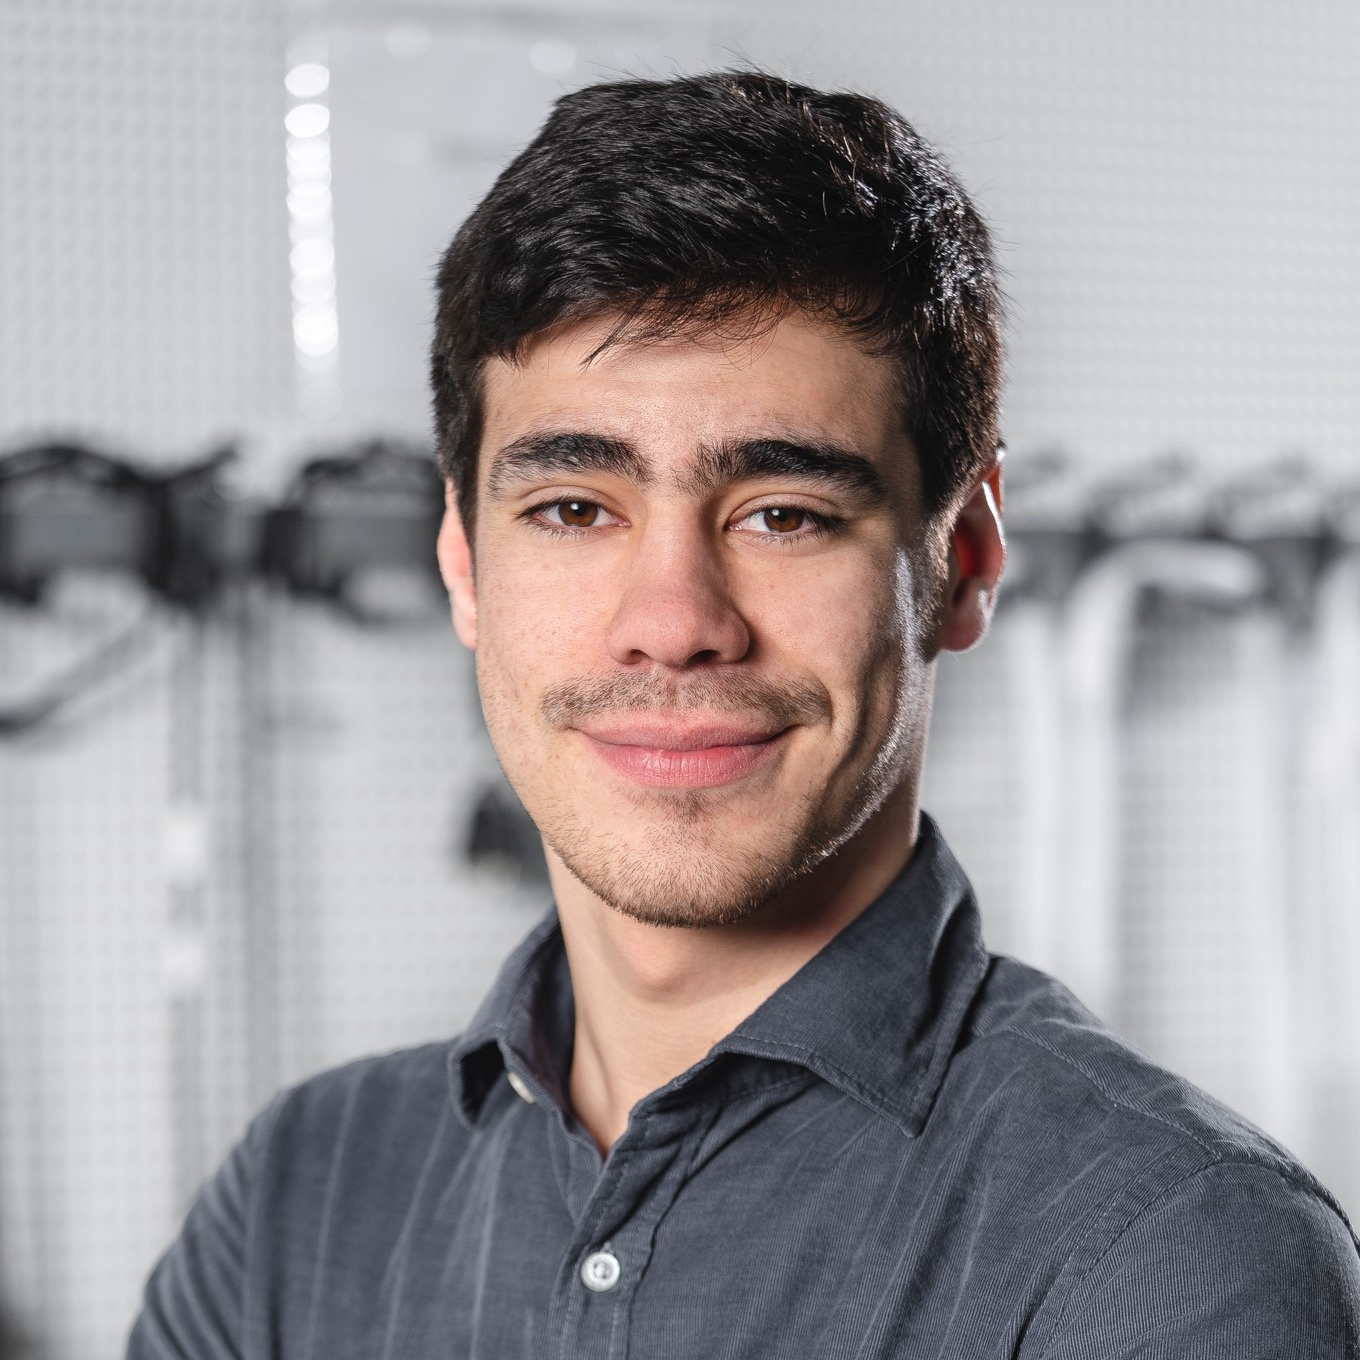

I believe you are human but you look like a 132.Xoloitzcuintli

Hello Mobylette!


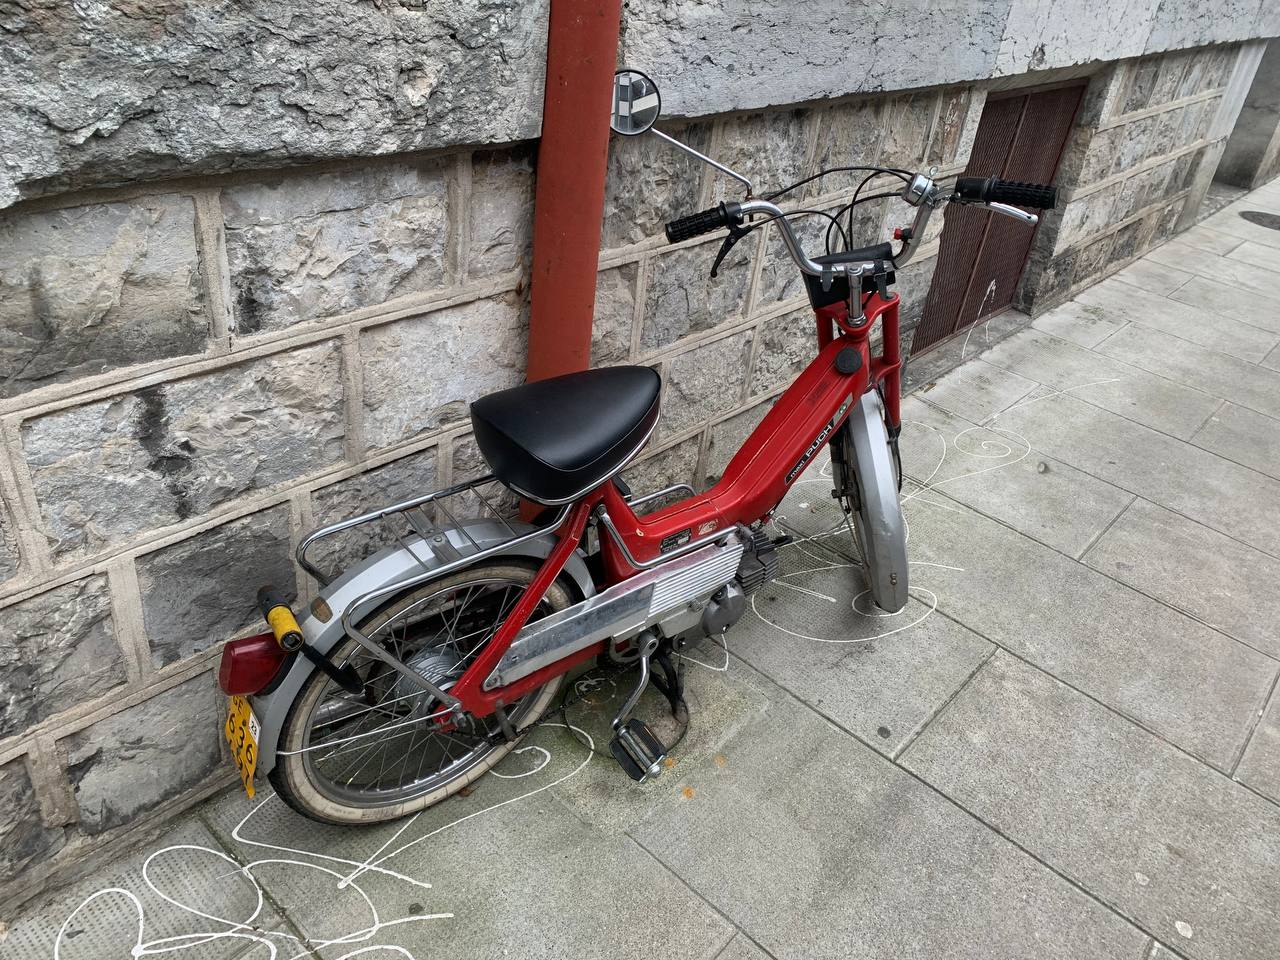

I can't tell if there's a human or a dog in this picture, can you show me another one ?



In [78]:

## Execute the algorithm from Step 6 on
## at  6 images from my  computer.


dog_identification_app('img/me.png', 'David')

dog_identification_app('img/cyclo.jpg', 'Mobylette')